In [ ]:
!pip install -U datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 14.1 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
  Attempting uninstall: datasets
    Found existing installation: datasets 2.14.4
    Uninstalling datasets-2.14.4:
      Successfully uninstalled datasets-2.14.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; pl

In [ ]:
!pip install torchinfo

In [ ]:
import matplotlib.pyplot as plt
import torch
import torchvision
from torch import nn
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
import os
import zipfile
from pathlib import Path
import requests

In [ ]:

# Plot linear data or training and test and predictions (optional)
def plot_predictions(
    train_data, train_labels, test_data, test_labels, predictions=None
):
    """
  Plots linear training data and test data and compares predictions.
  """
    plt.figure(figsize=(10, 7))

    # Plot training data in blue
    plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")

    # Plot test data in green
    plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

    if predictions is not None:
        # Plot the predictions in red (predictions were made on the test data)
        plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

    # Show the legend
    plt.legend(prop={"size": 14})


# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    """Calculates accuracy between truth labels and predictions.

    Args:
        y_true (torch.Tensor): Truth labels for predictions.
        y_pred (torch.Tensor): Predictions to be compared to predictions.

    Returns:
        [torch.float]: Accuracy value between y_true and y_pred, e.g. 78.45
    """
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc


def print_train_time(start, end, device=None):
    """Prints difference between start and end time.

    Args:
        start (float): Start time of computation (preferred in timeit format).
        end (float): End time of computation.
        device ([type], optional): Device that compute is running on. Defaults to None.

    Returns:
        float: time between start and end in seconds (higher is longer).
    """
    total_time = end - start
    print(f"\nTrain time on {device}: {total_time:.3f} seconds")
    return total_time


# Plot loss curves of a model
def plot_loss_curves(results):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """
    loss = results["train_loss"]
    test_loss = results["test_loss"]

    accuracy = results["train_acc"]
    test_accuracy = results["test_acc"]

    epochs = range(len(results["train_loss"]))

    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label="train_accuracy")
    plt.plot(epochs, test_accuracy, label="test_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()



from typing import List
import torchvision


def pred_and_plot_image(
    model: torch.nn.Module,
    image_path: str,
    class_names: List[str] = None,
    transform=None,
    device: torch.device = "cuda" if torch.cuda.is_available() else "cpu",
):


    # 1. Load in image and convert the tensor values to float32
    target_image = torchvision.io.read_image(str(image_path)).type(torch.float32)

    # 2. Divide the image pixel values by 255 to get them between [0, 1]
    target_image = target_image / 255.0

    # 3. Transform if necessary
    if transform:
        target_image = transform(target_image)

    # 4. Make sure the model is on the target device
    model.to(device)

    # 5. Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
        # Add an extra dimension to the image
        target_image = target_image.unsqueeze(dim=0)

        # Make a prediction on image with an extra dimension and send it to the target device
        target_image_pred = model(target_image.to(device))

    # 6. Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # 7. Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    # 8. Plot the image alongside the prediction and prediction probability
    plt.imshow(
        target_image.squeeze().permute(1, 2, 0)
    )
    if class_names:
        title = f"Pred: {class_names[target_image_pred_label.cpu()]} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    else:
        title = f"Pred: {target_image_pred_label} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    plt.title(title)
    plt.axis(False)

def set_seeds(seed: int=42):

    # Set the seed for general torch operations
    torch.manual_seed(seed)
    # Set the seed for CUDA torch operations (ones that happen on the GPU)
    torch.cuda.manual_seed(seed)

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
# 1. Get pretrained weights for ViT-Base
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT

# 2. Setup a ViT model instance with pretrained weights
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

# 3. Freeze the base parameters
for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False

class_names = ['real', 'fake']
set_seeds()
pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)
# pretrained_vit # uncomment for model output

In [ ]:
from torchinfo import summary

# Print a summary using torchinfo (uncomment for actual output)
summary(model=pretrained_vit,
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 2]              768                  Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    (590,592)            False
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              False
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 

In [ ]:
from datasets import load_dataset
ds = load_dataset("anson-huang/mirage-news", download_mode="force_redownload")

README.md:   0%|          | 0.00/2.01k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/655M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/143M [00:00<?, ?B/s]

test1_nyt_mj-00000-of-00001.parquet:   0%|          | 0.00/20.2M [00:00<?, ?B/s]

test2_bbc_dalle-00000-of-00002.parquet:   0%|          | 0.00/560M [00:00<?, ?B/s]

test2_bbc_dalle-00001-of-00002.parquet:   0%|          | 0.00/19.0M [00:00<?, ?B/s]

test3_cnn_dalle-00000-of-00002.parquet:   0%|          | 0.00/559M [00:00<?, ?B/s]

test3_cnn_dalle-00001-of-00002.parquet:   0%|          | 0.00/25.8M [00:00<?, ?B/s]

test4_bbc_sdxl-00000-of-00001.parquet:   0%|          | 0.00/46.0M [00:00<?, ?B/s]

test5_cnn_sdxl-00000-of-00001.parquet:   0%|          | 0.00/54.7M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2500 [00:00<?, ? examples/s]

Generating test1_nyt_mj split:   0%|          | 0/500 [00:00<?, ? examples/s]

Generating test2_bbc_dalle split:   0%|          | 0/500 [00:00<?, ? examples/s]

Generating test3_cnn_dalle split:   0%|          | 0/500 [00:00<?, ? examples/s]

Generating test4_bbc_sdxl split:   0%|          | 0/500 [00:00<?, ? examples/s]

Generating test5_cnn_sdxl split:   0%|          | 0/500 [00:00<?, ? examples/s]

In [ ]:
train_ds = ds["train"]
val_ds = ds["validation"]
test_ds =ds["test1_nyt_mj"]

In [ ]:
# Get automatic transforms from pretrained ViT weights
pretrained_vit_transforms = pretrained_vit_weights.transforms()
print(pretrained_vit_transforms)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [ ]:
import os
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from datasets import load_dataset
from PIL import Image

NUM_WORKERS = os.cpu_count()

# Custom dataset wrapper for HuggingFace Datasets
class HFDatasetWrapper(Dataset):
    def __init__(self, hf_dataset, transform=None):
        self.dataset = hf_dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        image = item['image']
        label = item['label']

        # Convert image to RGB if it's not already
        if image.mode != 'RGB':
            image = image.convert('RGB')

        if self.transform:
            image = self.transform(image)
        return image, label

def create_dataloaders(
    transform: transforms.Compose,
    batch_size: int,
    num_workers: int = NUM_WORKERS
):
    # Load the mirage-news dataset
    ds = load_dataset("anson-huang/mirage-news", download_mode="force_redownload")

    # Wrap the HuggingFace datasets into PyTorch Dataset objects
    train_dataset = HFDatasetWrapper(ds["train"], transform=transform)
    val_dataset   = HFDatasetWrapper(ds["validation"], transform=transform)
    test_dataset  = HFDatasetWrapper(ds["test1_nyt_mj"], transform=transform)

    # Create DataLoaders
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
    val_dataloader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)
    test_dataloader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)

    class_names = ['real', 'fake']  # Since labels are 0 (fake) or 1 (real)

    return train_dataloader, val_dataloader, test_dataloader, class_names

In [ ]:
train_dataloader_pretrained, val_dataloader_pretrained, test_dataloader_pretrained, class_names = create_dataloaders(
    transform=pretrained_vit_transforms,
    batch_size=32
)


train-00000-of-00001.parquet:   0%|          | 0.00/655M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/143M [00:00<?, ?B/s]

test1_nyt_mj-00000-of-00001.parquet:   0%|          | 0.00/20.2M [00:00<?, ?B/s]

test2_bbc_dalle-00000-of-00002.parquet:   0%|          | 0.00/560M [00:00<?, ?B/s]

test2_bbc_dalle-00001-of-00002.parquet:   0%|          | 0.00/19.0M [00:00<?, ?B/s]

test3_cnn_dalle-00000-of-00002.parquet:   0%|          | 0.00/559M [00:00<?, ?B/s]

test3_cnn_dalle-00001-of-00002.parquet:   0%|          | 0.00/25.8M [00:00<?, ?B/s]

test4_bbc_sdxl-00000-of-00001.parquet:   0%|          | 0.00/46.0M [00:00<?, ?B/s]

test5_cnn_sdxl-00000-of-00001.parquet:   0%|          | 0.00/54.7M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2500 [00:00<?, ? examples/s]

Generating test1_nyt_mj split:   0%|          | 0/500 [00:00<?, ? examples/s]

Generating test2_bbc_dalle split:   0%|          | 0/500 [00:00<?, ? examples/s]

Generating test3_cnn_dalle split:   0%|          | 0/500 [00:00<?, ? examples/s]

Generating test4_bbc_sdxl split:   0%|          | 0/500 [00:00<?, ? examples/s]

Generating test5_cnn_sdxl split:   0%|          | 0/500 [00:00<?, ? examples/s]

In [ ]:
import torch
from tqdm.auto import tqdm
from typing import Dict, List, Tuple

def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> Tuple[float, float]:

    model.train()
    train_loss, train_acc = 0, 0

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Forward pass
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # Backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Accuracy
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item() / len(y_pred)

    train_loss /= len(dataloader)
    train_acc /= len(dataloader)
    return train_loss, train_acc

def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:

    model.eval()
    test_loss, test_acc = 0, 0

    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)

            # Forward pass
            test_pred_logits = model(X)
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Accuracy
            test_pred_labels = torch.argmax(torch.softmax(test_pred_logits, dim=1), dim=1)
            test_acc += (test_pred_labels == y).sum().item() / len(test_pred_labels)

    test_loss /= len(dataloader)
    test_acc /= len(dataloader)
    return test_loss, test_acc

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List]:

    results = {"train_loss": [], "train_acc": [], "test_loss": [], "test_acc": []}
    model.to(device)

    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model, train_dataloader, loss_fn, optimizer, device)
        test_loss, test_acc = test_step(model, test_dataloader, loss_fn, device)

        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    return results


In [ ]:
# Create optimizer and loss function
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(),
                             lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

# Train the classifier head of the pretrained ViT feature extractor model
set_seeds()
pretrained_vit_results = train(model=pretrained_vit,
                                      train_dataloader=train_dataloader_pretrained,
                                      test_dataloader=test_dataloader_pretrained,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=10,
                                      device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.4358 | train_acc: 0.7996 | test_loss: 0.3607 | test_acc: 0.8336
Epoch: 2 | train_loss: 0.3279 | train_acc: 0.8594 | test_loss: 0.3308 | test_acc: 0.8570
Epoch: 3 | train_loss: 0.2960 | train_acc: 0.8753 | test_loss: 0.3094 | test_acc: 0.8672
Epoch: 4 | train_loss: 0.2773 | train_acc: 0.8830 | test_loss: 0.3037 | test_acc: 0.8789
Epoch: 5 | train_loss: 0.2652 | train_acc: 0.8922 | test_loss: 0.2966 | test_acc: 0.8652
Epoch: 6 | train_loss: 0.2595 | train_acc: 0.8928 | test_loss: 0.2917 | test_acc: 0.8711
Epoch: 7 | train_loss: 0.2523 | train_acc: 0.8969 | test_loss: 0.2916 | test_acc: 0.8828
Epoch: 8 | train_loss: 0.2465 | train_acc: 0.9003 | test_loss: 0.2921 | test_acc: 0.8809
Epoch: 9 | train_loss: 0.2432 | train_acc: 0.9017 | test_loss: 0.2931 | test_acc: 0.8828
Epoch: 10 | train_loss: 0.2402 | train_acc: 0.9013 | test_loss: 0.2907 | test_acc: 0.8809


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import torch
import numpy as np

def evaluate_model(model, dataloader, class_names, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)
            outputs = model(X)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.cpu().numpy())

    # Print metrics
    print("Classification Report:\n")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    print("Confusion Matrix:\n")
    print(confusion_matrix(all_labels, all_preds))


In [ ]:
evaluate_model(pretrained_vit, val_dataloader_pretrained, class_names, device)

Classification Report:

              precision    recall  f1-score   support

        real       0.88      0.87      0.88      1250
        fake       0.87      0.89      0.88      1250

    accuracy                           0.88      2500
   macro avg       0.88      0.88      0.88      2500
weighted avg       0.88      0.88      0.88      2500

Confusion Matrix:

[[1083  167]
 [ 142 1108]]


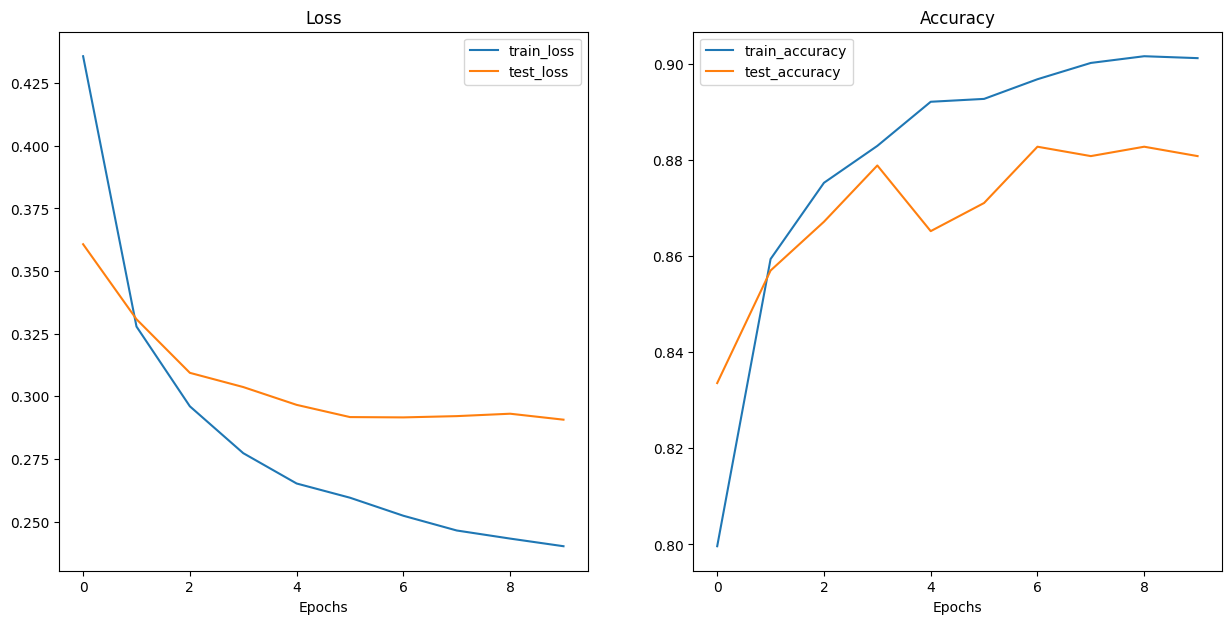

In [ ]:
plot_loss_curves(pretrained_vit_results)

In [ ]:
torch.save(pretrained_vit.state_dict(), "vit_image_model_weights.pth")

In [ ]:
!pip install -U huggingface_hub
from huggingface_hub import notebook_login

notebook_login()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 509.3/509.3 kB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 108.4 MB/s eta 0:00:00
  Attempting uninstall: huggingface_hub
    Found existing installation: huggingface-hub 0.31.2
    Uninstalling huggingface-hub-0.31.2:
      Successfully uninstalled huggingface-hub-0.31.2


In [ ]:
model_save_path = "vit_model.pth"
torch.save(pretrained_vit.state_dict(), model_save_path)

In [ ]:
from huggingface_hub import HfApi, HfFolder
import torch
import os # Import the os module

# Save model
model_dir = "vit-mirage-news"

# Create the directory if it doesn't exist
os.makedirs(model_dir, exist_ok=True)

pretrained_vit.cpu()
torch.save(pretrained_vit.state_dict(), f"{model_dir}/pytorch_model.bin")

# Save model config (optional but useful)
config = {
     "architecture": "vit_b_16",
   "labels": class_names,
   "input_size": [3, 224, 224],
   "transform": str(pretrained_vit_transforms)
}

import json
with open(f"{model_dir}/config.json", "w") as f:
  json.dump(config, f)

In [ ]:
from huggingface_hub import create_repo

repo_id = "darkam/vit-mirage-news"
create_repo(repo_id, private=False)

RepoUrl('https://huggingface.co/darkam/vit-mirage-news', endpoint='https://huggingface.co', repo_type='model', repo_id='darkam/vit-mirage-news')

In [ ]:
from huggingface_hub import upload_folder

upload_folder(
  repo_id=repo_id,
  folder_path=model_dir,
  path_in_repo="",
  commit_message="Upload ViT model fine-tuned on mirage-news"
)

pytorch_model.bin:   0%|          | 0.00/343M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/darkam/vit-mirage-news/commit/c07f1a2fd1dadfa94db353970e2b0c20c18f920e', commit_message='Upload ViT model fine-tuned on mirage-news', commit_description='', oid='c07f1a2fd1dadfa94db353970e2b0c20c18f920e', pr_url=None, repo_url=RepoUrl('https://huggingface.co/darkam/vit-mirage-news', endpoint='https://huggingface.co', repo_type='model', repo_id='darkam/vit-mirage-news'), pr_revision=None, pr_num=None)